In [1]:
import numpy as np
def four_state_simulation(position, alpha, beta, parameters, frame_rate, T):
    """Blinks simulation for a single fluorophore following four state four parameter (4P4S) model
    
    parameters
    ----------
    position: 2D coordinates [x,y] 
    alpha, beta: parameters for gamma distribution, which models the uncertainty
    parameters: the 4 parameters for the four state model, namely, 
        the intial turn-on rate, the turn-off rate, the subsequent turn-on rate and the bleach rate [k_i, k_d, k_a, k_b]  
    frame_rate: number of frames per unit time
    T: total time of acquisition
    
    returns
    -------
    numpy array with first column recording the frame number, 
    the second and third column the x, y position of the blink event, 
    and the fourth colum the uncertainty.
    """

    states = []
    times = []
    current_state = 'i'
    t = 0
    states.append(current_state)
    times.append(t)
    
    
    while t < T:
        if current_state == 'i':
            t_i = np.random.exponential(1/parameters[0])
            t = t + t_i
            current_state = 'a'
         
            
        elif current_state == 'a':
            t_a = np.random.exponential(1/(parameters[1] + parameters[3]))
            t = t + t_a
            p = np.random.uniform(0,1)
            if p < parameters[1] / (parameters[1] + parameters[3]):  
                current_state = 'd'         
            else:
                current_state = 'b' 
                      
                
        elif current_state == 'd':
            t_d = np.random.exponential(1/parameters[2])
            t = t + t_d
            current_state = 'a'
            
        
        elif current_state == 'b':
            t = T
            current_state = 'b'
        states.append(current_state)
        times.append(t)
    F = [] 
    dt = 1/frame_rate
    maxframe = int(T/dt)
    N = len(states)
    n = 1
    m = 1
    t = 0

    while m <= maxframe and n < N:
        
        if m*dt < times[n]:
            if states[n-1] == 'a':
                F.append([m, np.random.normal(position[0], 0.02), np.random.normal(position[1], 0.02), np.random.gamma(alpha,beta)])
            m = m + 1
        else:
            n = n + 1
    return np.array(F)

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
 
#Simulation window parameters
def ppp(xMin, xMax, yMin, yMax, lambda0):
    '''This function is to generate random points in a rectangular region accoring to Poisson point process
    parameters
    ----------
    xMin: the lower limit of x axis
    xMax: the upper limit of x axis
    yMin: the lower limit of y axis
    yMax: the upper limit of y axis
    lambda0: expected number of points per unit area
    
    returns
    -------
    numpy array with two columns where the first column is the x-coordinate and the second column is the y-coordinate

    '''

    xDelta=xMax-xMin
    yDelta=yMax-yMin #rectangle dimensions
    areaTotal=xDelta*yDelta
    
    #Point process parameters
    #intensity (ie mean density) of the Poisson process
    
    #Simulate Poisson point process
    numbPoints = scipy.stats.poisson( lambda0*areaTotal ).rvs()#Poisson number of points
    xx = xDelta*scipy.stats.uniform.rvs(0,1,(numbPoints,1))+xMin#x coordinates of Poisson points
    yy = yDelta*scipy.stats.uniform.rvs(0,1,(numbPoints,1))+yMin#y coordinates of Poisson points
    #Plotting
    # plt.scatter(xx,yy, edgecolor='b', facecolor='none', alpha=0.5 )
    # plt.xlabel("x"); plt.ylabel("y")
    return np.c_[xx,yy]

In [3]:
import numpy as np
def blinkpr(m, dt, k_i, k_off, k_on, k_pb):
    '''The function calcuates the probablity that a single fluorophore is in "turn-on" state in the m-th frame

    parameter
    ---------
    m: the frame ID
    dt: frame duration or the time interval between two consecutive frames
    k_i, k_on, k_off, k_pb: the 4 parameters for the four state model, namely, 
        the intial turn-on rate, the turn-off rate, the subsequent turn-on rate and the bleach rate [k_i, k_d, k_a, k_b] 
    
    return
    ------
    float number representing the probablity that a single fluorophore is in "turn-on" state in the m-th frame
    '''

    if m == 0:
        return 0
    else:
        sum = -(k_off + k_on + k_pb)
        product = k_on*k_pb
        lambda_plus = 0.5*(sum-(sum**2-4*product)**0.5)
        lambda_minus =  sum - lambda_plus

        A = 1/(-k_off-k_pb+k_i+k_on*k_off/(k_on-k_i))
        # B = A*(k_i*k_off/(k_on-k_i)+k_i-k_pb)
        C = A*(k_i*k_off/(-k_on+k_i)-k_i-lambda_plus*k_i/k_on)/(lambda_minus/k_on-lambda_plus/k_on)
        D = k_i*A - C

        p_on = -A*k_i*np.exp(-k_i*(m-1)*dt) + C*np.exp(lambda_plus*(m-1)*dt) + D*np.exp(lambda_minus*(m-1)*dt)
        p_off = A*k_i*k_off/(-k_on+k_i)*np.exp(-k_i*(m-1)*dt) + C*(-lambda_minus/k_on-1)*np.exp(lambda_plus*(m-1)*dt) + D*(-lambda_plus/k_on-1)*np.exp(lambda_minus*(m-1)*dt)
        p_0 = A*(-k_off-k_pb+k_i+k_on*k_off/(k_on-k_i))*np.exp(-k_i*(m-1)*dt)
        
        return p_on + p_off*(1-np.exp(-k_on*dt))+p_0*(1-np.exp(-k_i*dt))



In [4]:
def lambda_n(n, dt, k_i, k_off, k_on, k_pb):
    ''' This function calculates the sum of the probablity of a single fluorophore in "turn-on" states up to the n-th frame, denoted by lambda_n.
        parameter
        ---------
        n: total number of frames
        dt: frame duration or the time interval between two consecutive frames
        k_i, k_on, k_off, k_pb: the 4 parameters for the four state model, namely, 
            the intial turn-on rate, the turn-off rate, the subsequent turn-on rate and the bleach rate [k_i, k_d, k_a, k_b] 
        
        return
        ------
        float number: lambda_n    
    '''
    
    if n == 0:
        return 0
    else:
        return sum([blinkpr(i + 1, dt, k_i, k_off, k_on, k_pb) for i in range(n)])

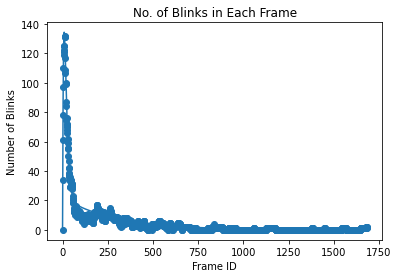

In [49]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import math

# initialize parameters

k_i = 15
k_off = 5
k_on = 1
k_pb = 3

parameters = np.array([k_i, k_off, k_on, k_pb])

framerate = 100
T = 100

N = 10
points = ppp(0,5,0,5,N)
blinks = np.empty((0,7))
sblink = np.zeros((points.shape[0],), dtype = int)

for i, point in enumerate(points):
    S = four_state_simulation(point, 2, 0.025, parameters, framerate, T)
    sblink = np.append(sblink,S.shape[0])
    if len(S) != 0:
        cols = np.empty((S.shape[0],3))
        for j in range(S.shape[0]):
            cols[j][0:2] = point[0], point[1]
            cols[j][2] = i
        blinks = np.r_[blinks,np.append(S,cols,1)]


blinksframes = np.array(blinks[:,0],dtype = int)
count = np.bincount(blinksframes)
prob = len(points)*np.array([blinkpr(i, 1/framerate, k_i, k_off, k_on, k_pb) for i in range(max(blinksframes) + 1)])

plt.scatter(range(max(blinksframes) + 1),count)
plt.plot(range(max(blinksframes) + 1), prob)
plt.xlabel('Frame ID')
plt.ylabel('Number of Blinks')
plt.title('No. of Blinks in Each Frame')

blinksinframes = np.c_[range(max(blinksframes) + 1), count]
# print(blinksinframes)

In [44]:
from scipy.stats import poisson
import numpy as np
L = lambda_n(max(blinksframes) + 1, 0.2, k_i, k_off, k_on, k_pb)
poisson_exp = len(points)*np.array([poisson.pmf(i, L) for i in range(max(sblink) + 1)])


"\nn, bins, patches = plt.hist(x = blinks, bins = range(50), color='#0504aa',\n                            alpha=0.7, rwidth=0.85)\nplt.grid(axis='y', alpha=0.75)\nplt.xlabel('Number of Blinks')\nplt.ylabel('Frequencies')\nplt.title('Histogram of no. of blinks on 1st frame')\nplt.text(25, 45, 'Number of simulations = 1000')\nmaxfreq = n.max()\n# Set a clean upper y-axis limit.\nplt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)\n\nr_i_est = - math.log(1 - sum(blinks)/(1000*N))*framerate\nprint(r_i_est)\n"

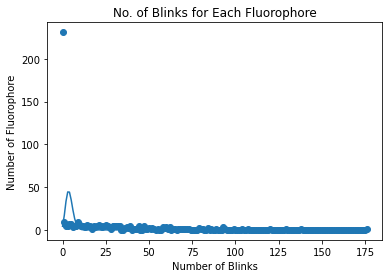

In [47]:
count = np.bincount(sblink)
# print(len(count))
# print(count)

plt.scatter(range(max(sblink) + 1),count)
plt.plot(range(max(sblink) + 1), poisson_exp)
plt.xlabel('Number of Blinks')
plt.ylabel('Number of Fluorophore')
plt.title('No. of Blinks for Each Fluorophore')

# blinksinframes = np.c_[range(max(blinksframes) + 1), count]
# print(blinksinframes)
'''
n, bins, patches = plt.hist(x = blinks, bins = range(50), color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of Blinks')
plt.ylabel('Frequencies')
plt.title('Histogram of no. of blinks on 1st frame')
plt.text(25, 45, 'Number of simulations = 1000')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

r_i_est = - math.log(1 - sum(blinks)/(1000*N))*framerate
print(r_i_est)
'''


In [46]:
import csv

def outputcsv(data):
    '''This function writes the simultion data into a csv file
    parameters
    ----------
    data: numpy array with 4 columns: 'frame', 'x', 'y', 'uncertainty_xy_nm'
    
    returns
    -------
    a csv file located at C:\\Users\e0293820\Documents\simulations.csv
    '''
    header = ['frame', 'x', 'y', 'uncertainty_xy_nm']

    with open('C:\\Users\e0293820\Documents\simulations.csv', 'w', encoding = 'UTF8', newline = '') as f:
        writer = csv.writer(f)

        # write the header
        writer.writerow(header)

        # write the data
        writer.writerows(data)

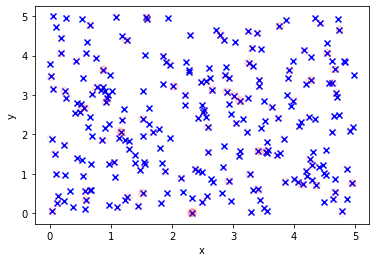

In [47]:
plt.scatter(points[:,0], points[:,1], marker = 'x', facecolor='b', alpha=1 )
plt.scatter(np.array(blinks)[:,1], np.array(blinks)[:,2], edgecolor = 'r', facecolor = 'none', alpha = 0.1)
plt.xlabel("x"); plt.ylabel("y")

outputcsv(blinks)

Estimated number of clusters: 73
Estimated number of noise points: 48


(array([29., 18., 15.,  4.,  3.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.]),
 array([ 2.        ,  2.84615385,  3.69230769,  4.53846154,  5.38461538,
         6.23076923,  7.07692308,  7.92307692,  8.76923077,  9.61538462,
        10.46153846, 11.30769231, 12.15384615, 13.        ]),
 <BarContainer object of 13 artists>)

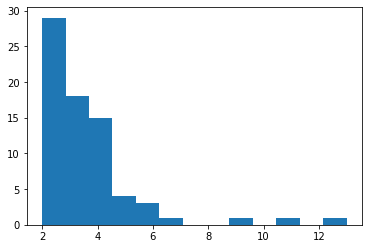

In [48]:
# DBSCAN

from sklearn.cluster import DBSCAN

def dbscanclustering(coordinates):
    clustering = DBSCAN(eps=0.09, min_samples=2).fit(coordinates)
    labels = clustering.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    return clustering


coordinates = np.array(blinks[:,1:3])
clustering = dbscanclustering(coordinates)
label = list(filter(lambda x: (x != -1), clustering.labels_))

cluster_size = np.bincount(label)
plt.hist(cluster_size, bins=max(cluster_size))

In [ ]:
import seaborn as sns
fig2, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot('x', 'y',

                data=DBSCAN_dataset[DBSCAN_dataset['Cluster']!=-1],

                hue='Cluster', ax=axes[0], palette='Set2', legend='full', s=200)